# Prereq
This notebook was developed on RAPIDS 21.08. Please use conda env or container from https://rapids.ai/start.html#get-rapids

# Setup
Please execute the following cell the first time to install packages and download data.

In [37]:
#!pip install biopython
#!wget https://zenodo.org/record/2543724/files/pubchem.chembl.dataset4publication_inchi_smiles_v2.tsv.xz?download=1 -O pubchem.chembl.dataset4publication_inchi_smiles_v2.tsv.xz
#!zstd -d pubchem.chembl.dataset4publication_inchi_smiles_v2.tsv.xz

In [38]:
import cudf
import cupy
from Bio import Entrez
from Bio.Entrez.Parser import ListElement
import matplotlib.pyplot as plt
import pandas as pd

Setup

In [39]:
# Please replace your email address here
Entrez.email = "rilango@nvidia.com"
data_file = '/rilango_data/data/ExcapeDB/data_v2.tsv'

EC_CACHE = {}

In [40]:
# This list is obtained from
# Chemformer - A Pre-Trained Transformer for Computational Chemistry - Supplementary_info_supplement_1
gene_list = ["ABL1", "ACHE", "ADAM17", "ADORA2A", "ADORA2B", "ADORA3", "ADRA1A", "ADRA1D", 
             "ADRB1", "ADRB2", "ADRB3", "AKT1", "AKT2", "ALK", "ALOX5", "AR", "AURKA", 
             "AURKB", "BACE1", "CA1", "CA12", "CA2", "CA9", "CASP1", "CCKBR", "CCR2", 
             "CCR5", "CDK1", "CDK2", "CHEK1", "CHRM1", "CHRM2", "CHRM3", "CHRNA7", "CLK4", 
             "CNR1", "CNR2", "CRHR1", "CSF1R", "CTSK", "CTSS", "CYP19A1", "DHFR", "DPP4", 
             "DRD1", "DRD3", "DRD4", "DYRK1A", "EDNRA", "EGFR", "EPHX2", "ERBB2", "ESR1", 
             "ESR2", "F10", "F2", "FAAH", "FGFR1", "FLT1", "FLT3", "GHSR", "GNRHR", "GRM5", 
             "GSK3A", "GSK3B", "HDAC1", "HPGD", "HRH3", "HSD11B1", "HSP90AA1", "HTR2A", 
             "HTR2C", "HTR6", "HTR7", "IGF1R", "INSR", "ITK", "JAK2", "JAK3", "KCNH2", 
             "KDR", "KIT", "LCK", "MAOB", "MAPK14", "MAPK8", "MAPK9", "MAPKAPK2", "MC4R", 
             "MCHR1", "MET", "MMP1", "MMP13", "MMP2", "MMP3", "MMP9", "MTOR", "NPY5R", 
             "NR3C1", "NTRK1", "OPRD1", "OPRK1", "OPRL1", "OPRM1", "P2RX7", "PARP1", "PDE5A", 
             "PDGFRB", "PGR", "PIK3CA", "PIM1", "PIM2", "PLK1", "PPARA", "PPARD", "PPARG", 
             "PRKACA", "PRKCD", "PTGDR2", "PTGS2", "PTPN1", "REN", "ROCK1", "ROCK2", "S1PR1", 
             "SCN9A", "SIGMAR1", "SLC6A2", "SLC6A3", "SRC", "TACR1", "TRPV1", "VDR"]

In [41]:
def get_ec_num(rec):
    """
    Helper function to extract EC number from record
    """
    ecs = []

    if isinstance(rec, ListElement):
        for r in rec:
            ecs.extend(get_ec_num(r))
    elif 'Gene-commentary_label' in rec and rec['Gene-commentary_label'] == 'EC':
        ecs.append(rec['Gene-commentary_text'])
    elif 'Gene-commentary_comment' in rec:
        ecs.extend(get_ec_num(rec['Gene-commentary_comment']))
    elif 'Gene-commentary_products' in rec:
        ecs.extend(get_ec_num(rec['Gene-commentary_products']))

    return ecs

def fetch_entrez_info(entrez_id):

    if entrez_id not in EC_CACHE:
        handle = Entrez.efetch(db="gene", id=entrez_id, retmode = "xml")
        recs = Entrez.read(handle)
        ecs = []
        for rec in recs:
            for locus in rec['Entrezgene_locus']:
                ecs.extend(get_ec_num(locus))

        ecs = list(set(ecs))

        EC_CACHE[entrez_id] = (str(ecs), recs[0]['Entrezgene_gene']['Gene-ref']['Gene-ref_desc'])

    return EC_CACHE[entrez_id]

In [42]:
# Load data. Here only required fields are loaded. Please use the wget command 
# in the first cell to download data. Please extract it before using it.
data = cudf.read_csv(data_file,
                     delimiter='\t',
                     usecols=['Entrez_ID', 'pXC50', 'Gene_Symbol'])
data.shape

(70850163, 3)

In [43]:
data = data[data.Gene_Symbol.isin(gene_list)]
data.to_csv('Filtered_summary.csv')
data['Cnt'] = cupy.zeros(data.shape[0])
data.head()

,Entrez_ID,pXC50,Gene_Symbol,Cnt
0,2064,7.19382,ERBB2,0.0
1,1956,6.73,EGFR,0.0
8,3248,4.85,HPGD,0.0
34,1128,<NA>,CHRM1,0.0
43,154,<NA>,ADRB2,0.0


In [44]:
# Group by Entrez_ID and compute data for each Entrez_ID
data = data.set_index(['Gene_Symbol', 'Entrez_ID'])
grouped_df = data.groupby(level=['Entrez_ID', 'Gene_Symbol'])

count_df = grouped_df.count()
count_df.drop('pXC50', axis=1, inplace=True)
count_df = count_df.sort_values('Cnt', ascending=False)
count_df['pXC50_min'] = grouped_df.pXC50.min()
count_df['pXC50_max'] = grouped_df.pXC50.max()
summary = count_df.to_pandas()
summary.head()

,,Cnt,pXC50_min,pXC50_max
Entrez_ID,Gene_Symbol,,,
1814,DRD3,405348,3.10000,11.55280
7421,VDR,391988,3.21000,11.70000
6868,ADAM17,367067,3.74000,10.59000
15558,HTR2A,359985,4.11885,8.42022
1128,CHRM1,357391,2.21000,12.00000


In [45]:
summary.head(), summary.shape, len(gene_list)
summary = summary.sort_values(['Gene_Symbol', 'Entrez_ID'], ascending=True)
summary

,,Cnt,pXC50_min,pXC50_max
Entrez_ID,Gene_Symbol,,,
25,ABL1,2015,3.41,10.8000
43,ACHE,3044,1.30,11.7700
11423,ACHE,226,2.46,12.3900
83817,ACHE,1042,1.32,11.0500
6868,ADAM17,367067,3.74,10.5900
...,...,...,...,...
7442,TRPV1,316003,2.78,12.0000
83810,TRPV1,1134,3.64,10.7000
7421,VDR,391988,3.21,11.7000


Following code uses Entrez_ID to query NCBI DB to fetch EC number. This may take 
a while to fetch all EC numbers.

In [46]:
# Fetch EC numbers using BioPython
# data = data[data.Gene_Symbol.isin(gene_list)]

all_ecs = []
names = []
for entrez_id in summary.index.get_level_values('Entrez_ID'):
    ecs, desc = fetch_entrez_info(entrez_id)
    all_ecs.append(ecs)
    names.append(desc)

summary['EC'] = all_ecs
summary['name'] = names

summary = summary[['name', 'EC', 'Cnt', 'pXC50_min',	'pXC50_max']]
summary = summary.sort_values(['Cnt'], ascending=True)
summary.to_csv('Gene-Entrez_ID-wise_summary.csv')
summary.head()

Plot the histgram visializing density of count.

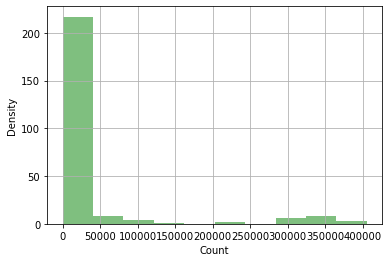

In [ ]:
# summary = pd.read_csv('summary.csv')
plt.hist(summary['Cnt'].values, 10, facecolor='g', alpha=0.50)
plt.xlabel('Count')
plt.ylabel('Density')
plt.grid(True)
plt.show()